# Survival Analysis 
This notebook focuses on the implementation of Cox Model and other survival analysis techniques

### Data Description
- Age: Age of patient at time of operation
- Operation_year: Patient's year of operation (year - 19XX)
- Nb_pos_detected: Number of positive axillary nodes detected
- Surv: Survival status (class attribute) 1 = the patient survived 5 years or longer 2 = the patient died within 5 year

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/home/pleyva/miniconda3/envs/ML/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv('./data/haberman.csv', names = ['Age','Operation_year','Nb_pos_detected','Surv'])
data.head(5)

,Age,Operation_year,Nb_pos_detected,Surv
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


## 1. Data Quality Assessment


In [3]:
from scipy import stats
from scipy.stats import shapiro, mannwhitneyu, chi2_contingency
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# Set style for professional visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
# Data Quality Checks
print("=" * 60)
print("DATA QUALITY ASSESSMENT")
print("=" * 60)

# Basic info
print("\n1. Dataset Shape:")
print(f"   Rows: {data.shape[0]}, Columns: {data.shape[1]}")

# Missing values
print("\n2. Missing Values:")
missing = data.isnull().sum()
if missing.sum() == 0:
    print("   ✓ No missing values")
else:
    print(missing[missing > 0])

# Duplicate rows
print("\n3. Duplicate Rows:")
duplicates = data.duplicated().sum()
print(f"   {duplicates} duplicate row(s) found")

# Data types
print("\n4. Data Types:")
print(data.dtypes)

# Memory usage
print(f"\n5. Memory Usage: {data.memory_usage(deep=True).sum() / 1024:.2f} KB")

# Convert Surv to categorical
data['Surv'] = data['Surv'].astype('category')
print("\n6. Target variable converted to categorical type")


DATA QUALITY ASSESSMENT

1. Dataset Shape:
   Rows: 306, Columns: 4

2. Missing Values:
   ✓ No missing values

3. Duplicate Rows:
   17 duplicate row(s) found

4. Data Types:
Age                int64
Operation_year     int64
Nb_pos_detected    int64
Surv               int64
dtype: object

5. Memory Usage: 9.69 KB

6. Target variable converted to categorical type



7. Outlier Detection using IQR method:

   Age:
   - Lower bound: 18.88, Upper bound: 85.88
   - Outliers count: 0 (0.0%)

   Operation_year:
   - Lower bound: 51.38, Upper bound: 74.38
   - Outliers count: 0 (0.0%)

   Nb_pos_detected:
   - Lower bound: -6.00, Upper bound: 10.00
   - Outliers count: 40 (13.1%)
   - Outlier values: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 30, 35, 46, 52]


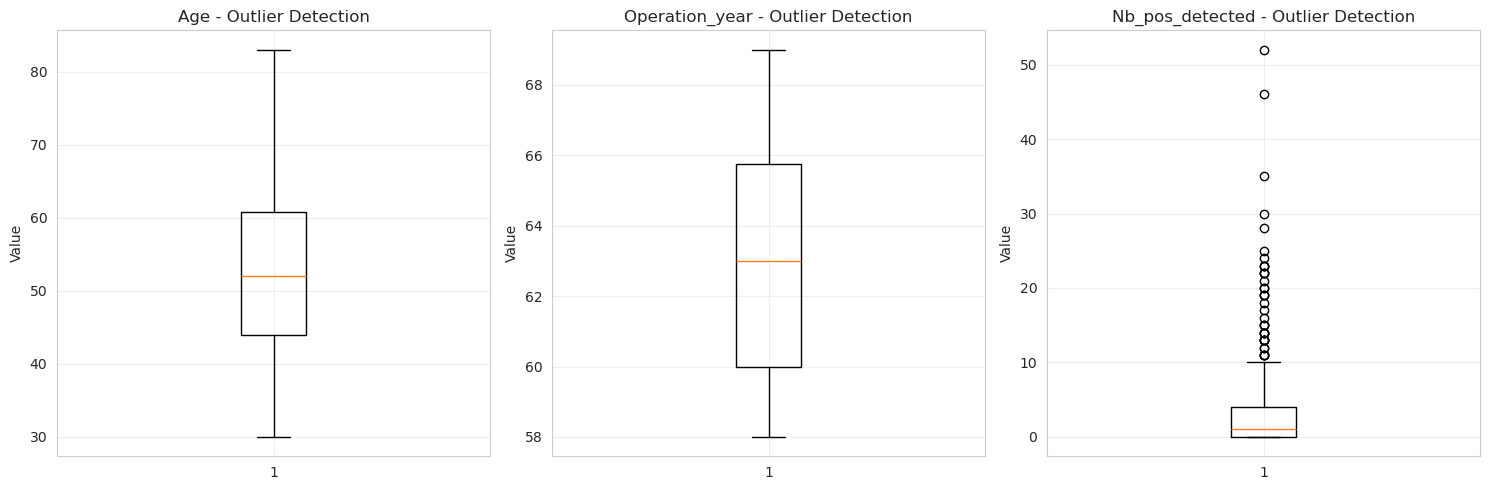

In [5]:
# Outlier Detection
print("\n7. Outlier Detection using IQR method:")
numerical_cols = ['Age', 'Operation_year', 'Nb_pos_detected']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, col in enumerate(numerical_cols):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    print(f"\n   {col}:")
    print(f"   - Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
    print(f"   - Outliers count: {len(outliers)} ({len(outliers)/len(data)*100:.1f}%)")
    if len(outliers) > 0:
        print(f"   - Outlier values: {sorted(outliers[col].unique().tolist())}")
    
    # Box plot
    axes[idx].boxplot(data[col], vert=True)
    axes[idx].set_title(f'{col} - Outlier Detection')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [6]:
# Validate data ranges
print("\n8. Data Range Validation:")
print(f"   Age: {data['Age'].min()}-{data['Age'].max()} years")
print(f"   Operation Year: {data['Operation_year'].min()}-{data['Operation_year'].max()} (i.e., 19{data['Operation_year'].min()}-19{data['Operation_year'].max()})")
print(f"   Positive Nodes: {data['Nb_pos_detected'].min()}-{data['Nb_pos_detected'].max()}")
print(f"   Survival: {data['Surv'].value_counts().to_dict()} (1=Survived ≥5y, 2=Died <5y)")



8. Data Range Validation:
   Age: 30-83 years
   Operation Year: 58-69 (i.e., 1958-1969)
   Positive Nodes: 0-52
   Survival: {1: 225, 2: 81} (1=Survived ≥5y, 2=Died <5y)


## 2. Univariate Analysis


In [7]:
# Comprehensive Summary Statistics
print("=" * 60)
print("UNIVARIATE ANALYSIS - SUMMARY STATISTICS")
print("=" * 60)

numerical_cols = ['Age', 'Operation_year', 'Nb_pos_detected']
stats_df = pd.DataFrame({
    'Mean': data[numerical_cols].mean(),
    'Median': data[numerical_cols].median(),
    'Mode': [data[col].mode()[0] for col in numerical_cols],
    'Std Dev': data[numerical_cols].std(),
    'Skewness': data[numerical_cols].skew(),
    'Kurtosis': data[numerical_cols].kurtosis(),
    'Min': data[numerical_cols].min(),
    'Max': data[numerical_cols].max()
})

print("\nDetailed Statistics:")
print(stats_df.round(3))


UNIVARIATE ANALYSIS - SUMMARY STATISTICS

Detailed Statistics:
                   Mean  Median  Mode  Std Dev  Skewness  Kurtosis  Min  Max
Age              52.458    52.0    52   10.803     0.147    -0.589   30   83
Operation_year   62.853    63.0    58    3.249     0.079    -1.119   58   69
Nb_pos_detected   4.026     1.0     0    7.190     2.984    11.731    0   52


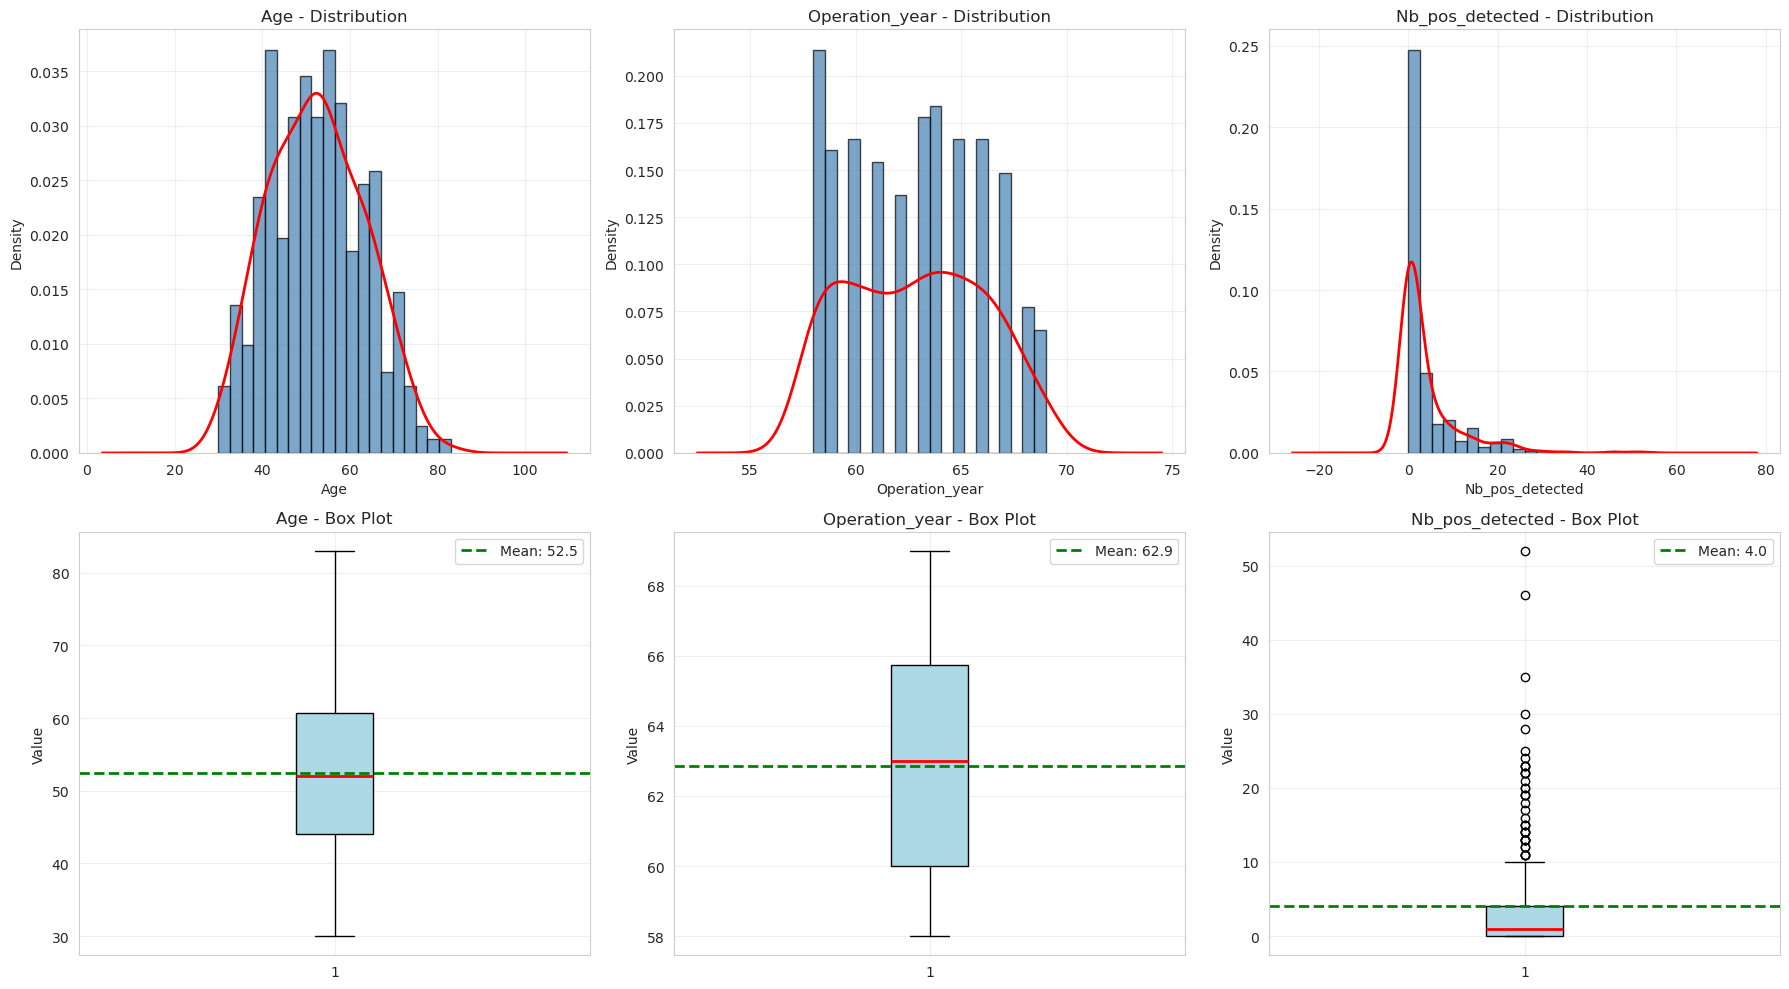

In [8]:
# Distribution Plots for Numerical Features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, col in enumerate(numerical_cols):
    # Histogram with KDE overlay
    axes[0, idx].hist(data[col], bins=20, density=True, alpha=0.7, color='steelblue', edgecolor='black')
    data[col].plot.density(ax=axes[0, idx], linewidth=2, color='red')
    axes[0, idx].set_title(f'{col} - Distribution')
    axes[0, idx].set_xlabel(col)
    axes[0, idx].set_ylabel('Density')
    axes[0, idx].grid(True, alpha=0.3)
    
    # Box plot
    bp = axes[1, idx].boxplot(data[col], patch_artist=True, 
                               boxprops=dict(facecolor='lightblue'),
                               medianprops=dict(color='red', linewidth=2))
    axes[1, idx].set_title(f'{col} - Box Plot')
    axes[1, idx].set_ylabel('Value')
    axes[1, idx].grid(True, alpha=0.3)
    
    # Add mean line
    mean_val = data[col].mean()
    axes[1, idx].axhline(y=mean_val, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    axes[1, idx].legend()

plt.tight_layout()
plt.show()


TARGET VARIABLE - SURVIVAL STATUS

Class Distribution:
  Survived ≥5 years: 225 cases (73.5%)
  Died <5 years: 81 cases (26.5%)

Class Imbalance Ratio: 2.78:1


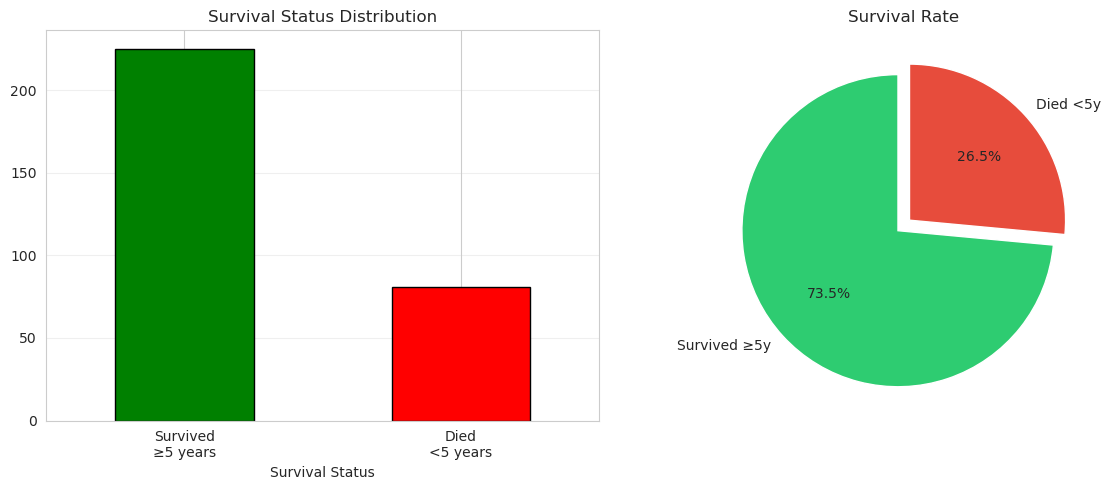

In [9]:
# Target Variable Analysis
print("=" * 60)
print("TARGET VARIABLE - SURVIVAL STATUS")
print("=" * 60)

survival_counts = data['Surv'].value_counts()
survival_pct = data['Surv'].value_counts(normalize=True) * 100

print("\nClass Distribution:")
for idx, count in survival_counts.items():
    status = "Survived ≥5 years" if idx == 1 else "Died <5 years"
    print(f"  {status}: {count} cases ({survival_pct[idx]:.1f}%)")

print(f"\nClass Imbalance Ratio: {max(survival_counts) / min(survival_counts):.2f}:1")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

survival_counts.plot(kind='bar', ax=axes[0], color=['green', 'red'], edgecolor='black')
axes[0].set_title('Survival Status Distribution')
axes[0].set_xlabel('Survival Status')
axes[0].set_xticklabels(['Survived\n≥5 years', 'Died\n<5 years'], rotation=0)
axes[0].grid(True, alpha=0.3, axis='y')

colors = ['#2ecc71', '#e74c3c']
axes[1].pie(survival_pct, labels=['Survived ≥5y', 'Died <5y'], 
           autopct='%1.1f%%', colors=colors, startangle=90,
           explode=(0.05, 0.05))
axes[1].set_title('Survival Rate')

plt.tight_layout()
plt.show()


## 3. Bivariate Analysis


BIVARIATE ANALYSIS - BY SURVIVAL STATUS

Grouped Statistics by Survival Status:
                   Age               Operation_year               \
                  mean median    std           mean median   std   
Survival_Status                                                    
Survived         52.02   52.0  11.01          62.86   63.0  3.22   
Died             53.68   53.0  10.17          62.83   63.0  3.34   

                Nb_pos_detected               
                           mean median   std  
Survival_Status                               
Survived                   2.79    0.0  5.87  
Died                       7.46    4.0  9.19  


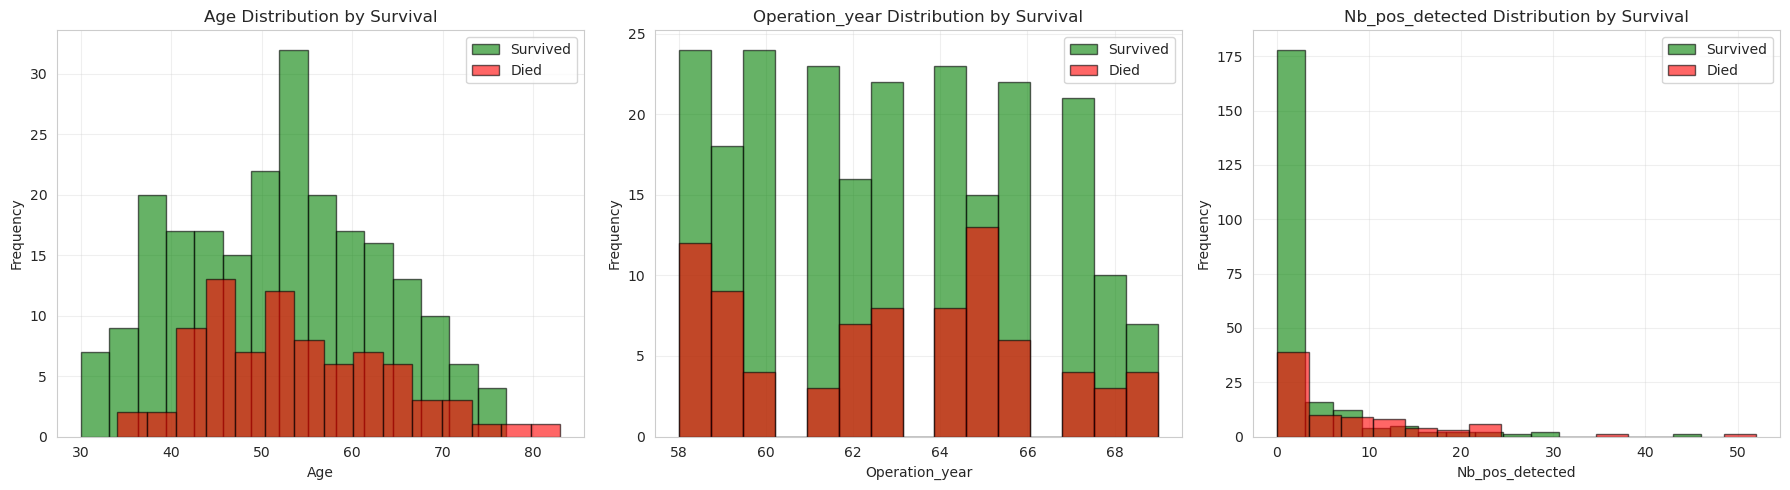

In [10]:
# Bivariate Analysis - Compare Features by Survival Status
print("=" * 60)
print("BIVARIATE ANALYSIS - BY SURVIVAL STATUS")
print("=" * 60)

# Create survival labels
data['Survival_Status'] = data['Surv'].map({1: 'Survived', 2: 'Died'})
survived = data[data['Surv'] == 1]
died = data[data['Surv'] == 2]

# Grouped statistics
grouped_stats = data.groupby('Survival_Status')[numerical_cols].agg(['mean', 'median', 'std'])
print("\nGrouped Statistics by Survival Status:")
print(grouped_stats.round(2))

# Distribution comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(survived[col], bins=15, alpha=0.6, label='Survived', color='green', edgecolor='black')
    axes[idx].hist(died[col], bins=15, alpha=0.6, label='Died', color='red', edgecolor='black')
    axes[idx].set_title(f'{col} Distribution by Survival')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Correlation Analysis


CORRELATION ANALYSIS


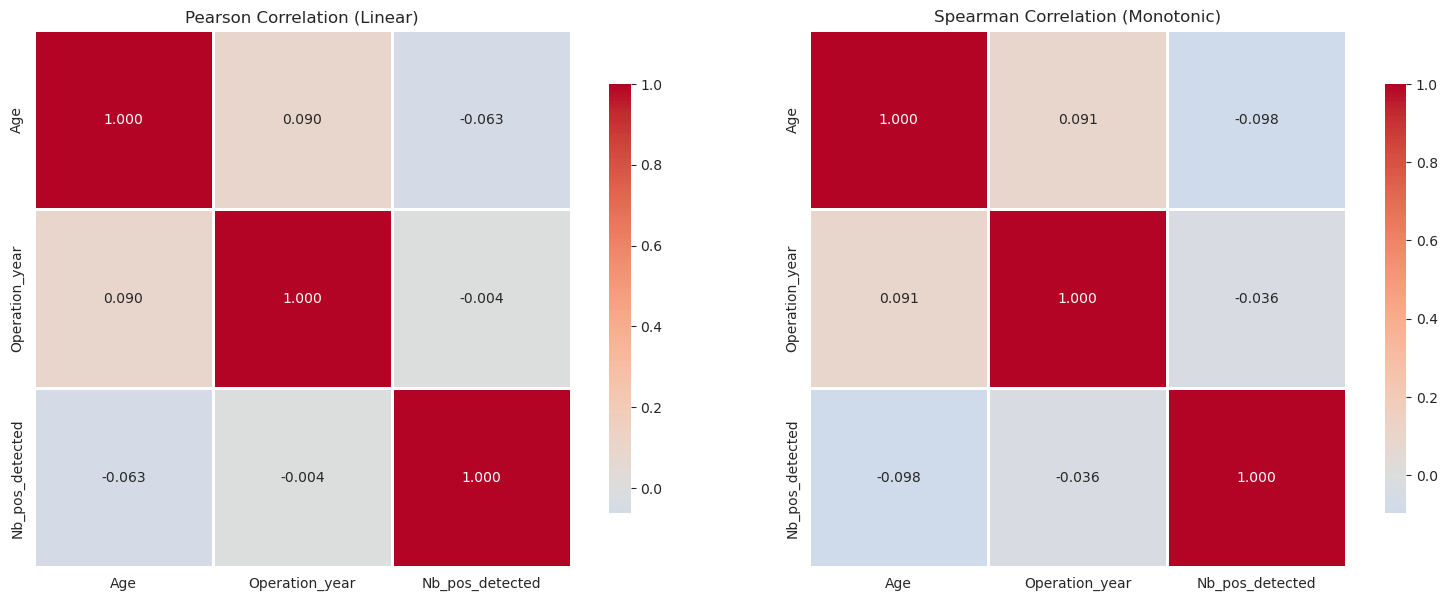


Pearson Correlations:
                   Age  Operation_year  Nb_pos_detected
Age              1.000           0.090           -0.063
Operation_year   0.090           1.000           -0.004
Nb_pos_detected -0.063          -0.004            1.000

Spearman Correlations:
                   Age  Operation_year  Nb_pos_detected
Age              1.000           0.091           -0.098
Operation_year   0.091           1.000           -0.036
Nb_pos_detected -0.098          -0.036            1.000


In [11]:
# Correlation Analysis
print("=" * 60)
print("CORRELATION ANALYSIS")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pearson correlation
pearson_corr = data[numerical_cols].corr(method='pearson')
sns.heatmap(pearson_corr, annot=True, fmt='.3f', cmap='coolwarm', 
           center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[0])
axes[0].set_title('Pearson Correlation (Linear)')

# Spearman correlation
spearman_corr = data[numerical_cols].corr(method='spearman')
sns.heatmap(spearman_corr, annot=True, fmt='.3f', cmap='coolwarm', 
           center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[1])
axes[1].set_title('Spearman Correlation (Monotonic)')

plt.tight_layout()
plt.show()

print("\nPearson Correlations:")
print(pearson_corr.round(3))
print("\nSpearman Correlations:")
print(spearman_corr.round(3))


## 5. Pair Plot Analysis


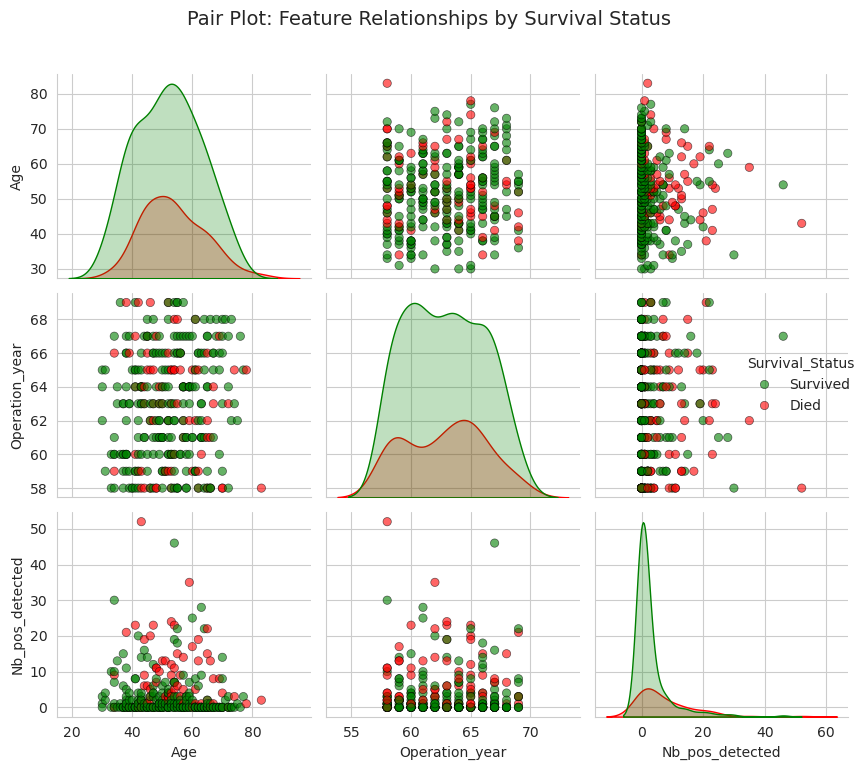

In [12]:
# Pair plot colored by survival status
sns.pairplot(data[['Age', 'Operation_year', 'Nb_pos_detected', 'Survival_Status']], 
             hue='Survival_Status', diag_kind='kde',
             palette={'Survived': 'green', 'Died': 'red'}, 
             plot_kws={'alpha': 0.6, 'edgecolor': 'black'})
plt.suptitle('Pair Plot: Feature Relationships by Survival Status', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


## 6. Key Insights and Summary


In [13]:
print("=" * 70)
print("COMPREHENSIVE EDA - KEY INSIGHTS SUMMARY")
print("=" * 70)

# Calculate overall survival rate
overall_survival = (data['Surv'] == 1).sum() / len(data) * 100
survival_counts = data['Surv'].value_counts()

insights = f"""
## DATASET OVERVIEW
- Total samples: {len(data)}
- Features: 3 numerical features (Age, Operation Year, Positive Nodes)
- Target: Binary survival classification (5-year survival)

## DATA QUALITY
✓ No missing values
✓ Data ranges validated
- Notable outliers in 'Positive Nodes' feature (max: {data['Nb_pos_detected'].max()} nodes)

## CLASS IMBALANCE
⚠️ Significant class imbalance present
- Survival rate: {overall_survival:.1f}%
- Mortality rate: {100 - overall_survival:.1f}%
- Class ratio: {max(survival_counts) / min(survival_counts):.2f}:1
- WARNING: Imbalanced dataset requires careful model evaluation

## KEY FINDINGS

### Feature Distributions
- Age: Mean {data['Age'].mean():.1f} years (range {data['Age'].min()}-{data['Age'].max()})
- Positive Nodes: Right-skewed (median: {data['Nb_pos_detected'].median()}, mean: {data['Nb_pos_detected'].mean():.1f})
- Operation Year: Range 1958-1969 (historical data)

### Feature-Survival Associations
- Positive Nodes: Strongest predictor (higher nodes → lower survival)
- Age: Moderate association with survival
- Operation Year: Weak association (temporal effects minimal)

### Feature Correlations
- Low inter-feature correlations (multicollinearity not a concern)
- Features appear relatively independent

## MODELING RECOMMENDATIONS

### For Cox Regression / Survival Analysis:
1. Use all three features as predictors
2. Consider transforming skewed features (e.g., log-transform for positive nodes)
3. Address class imbalance in evaluation (use stratified CV, balanced metrics)
4. Consider feature interaction terms (Age × Positive Nodes)

### Evaluation Strategy:
- Use precision-recall metrics (not just accuracy)
- Use stratified train-test split
- Consider SMOTE or class weights for imbalanced learning
- Focus on correctly predicting deaths (minority class)

### Alternative Approaches:
- Logistic regression with interaction terms
- Tree-based models (Random Forest, XGBoost)
- Ensemble methods combining multiple approaches
"""

print(insights)


COMPREHENSIVE EDA - KEY INSIGHTS SUMMARY

## DATASET OVERVIEW
- Total samples: 306
- Features: 3 numerical features (Age, Operation Year, Positive Nodes)
- Target: Binary survival classification (5-year survival)

## DATA QUALITY
✓ No missing values
✓ Data ranges validated
- Notable outliers in 'Positive Nodes' feature (max: 52 nodes)

## CLASS IMBALANCE
⚠️ Significant class imbalance present
- Survival rate: 73.5%
- Mortality rate: 26.5%
- Class ratio: 2.78:1
- WARNING: Imbalanced dataset requires careful model evaluation

## KEY FINDINGS

### Feature Distributions
- Age: Mean 52.5 years (range 30-83)
- Positive Nodes: Right-skewed (median: 1.0, mean: 4.0)
- Operation Year: Range 1958-1969 (historical data)

### Feature-Survival Associations
- Positive Nodes: Strongest predictor (higher nodes → lower survival)
- Age: Moderate association with survival
- Operation Year: Weak association (temporal effects minimal)

### Feature Correlations
- Low inter-feature correlations (multicollinea

# Survival Analysis Implementation

This section implements comprehensive survival analysis using:
1. **Kaplan-Meier Curves**: Non-parametric estimation of survival probability over time
2. **Log-Rank Tests**: Statistical comparison of survival curves between groups
3. **Cox Proportional Hazards Regression**: Modeling the effect of covariates on survival


In [14]:
# Install lifelines if needed (uncomment if necessary)
# !pip install lifelines

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, pairwise_logrank_test, multivariate_logrank_test
from lifelines.utils import k_fold_cross_validation
import warnings
warnings.filterwarnings('ignore')

print("Survival analysis libraries imported successfully")


Survival analysis libraries imported successfully


## Data Preparation for Survival Analysis

Since the Haberman dataset contains only binary 5-year survival outcomes (not exact time-to-event), we need to:
1. Create a time variable (assume 60 months for survived, distribute deaths across 60 months)
2. Create an event indicator (1=death, 0=censored/survived)
3. Engineer categorical features for stratification


In [15]:
# Create survival time and event variables
# Note: Since we only have 5-year binary survival, we'll create pseudo time-to-event data

# Reload data to ensure clean state
data_clean = data[['Age', 'Operation_year', 'Nb_pos_detected', 'Surv']].copy()

# Create event indicator: 1 = death (died within 5 years), 0 = survived/censored
data_clean['event'] = (data_clean['Surv'] == 2).astype(int)

# Create time variable (in months)
# For those who died (Surv=2): assume death occurred at random point between 0-60 months
# For those who survived (Surv=1): censor at 60 months (survived to at least 5 years)
np.random.seed(42)  # For reproducibility

died_indices = data_clean['Surv'] == 2
n_died = died_indices.sum()

# Distribute deaths uniformly across 60 months (most conservative approach)
# Alternative: could use exponential or Weibull distribution
# Initialize all times to 60 (censored/survived)
data_clean['time'] = 60.0
# Update only the died indices with random death times
data_clean.loc[died_indices, 'time'] = np.random.uniform(1, 60, n_died)

# Convert to integers for cleaner presentation
data_clean['time'] = data_clean['time'].astype(int)

print("Data preparation complete:")
print(f"\nEvent distribution:")
print(data_clean['event'].value_counts())
print(f"\nTime variable statistics:")
print(data_clean['time'].describe())
print(f"\nFirst 10 rows:")
print(data_clean.head(10))


Data preparation complete:

Event distribution:
0    225
1     81
Name: event, dtype: int64

Time variable statistics:
count    306.000000
mean      51.611111
std       16.797221
min        1.000000
25%       57.000000
50%       60.000000
75%       60.000000
max       60.000000
Name: time, dtype: float64

First 10 rows:
   Age  Operation_year  Nb_pos_detected Surv  event  time
0   30              64                1    1      0    60
1   30              62                3    1      0    60
2   30              65                0    1      0    60
3   31              59                2    1      0    60
4   31              65                4    1      0    60
5   33              58               10    1      0    60
6   33              60                0    1      0    60
7   34              59                0    2      1    23
8   34              66                9    2      1    57
9   34              58               30    1      0    60


In [16]:
# Feature Engineering for Survival Analysis

# Age groups
data_clean['age_group'] = pd.cut(data_clean['Age'], bins=[0, 45, 55, 65, 100], 
                                  labels=['<45', '45-55', '55-65', '>65'])

# Node categories (more refined than EDA)
data_clean['node_category'] = pd.cut(data_clean['Nb_pos_detected'], 
                                     bins=[-1, 0, 3, 9, 100], 
                                     labels=['0', '1-3', '4-9', '≥10'])

# Operation year periods
data_clean['op_period'] = pd.cut(data_clean['Operation_year'], 
                                 bins=[57, 62, 66, 70], 
                                 labels=['1958-61', '1962-65', '1966-69'])

print("Feature engineering complete:")
print(f"\nAge groups: {data_clean['age_group'].value_counts().to_dict()}")
print(f"\nNode categories: {data_clean['node_category'].value_counts().to_dict()}")
print(f"\nOperation periods: {data_clean['op_period'].value_counts().to_dict()}")


Feature engineering complete:

Age groups: {'45-55': 101, '<45': 89, '55-65': 78, '>65': 38}

Node categories: {'0': 136, '1-3': 81, '4-9': 46, '≥10': 43}

Operation periods: {'1958-61': 140, '1962-65': 117, '1966-69': 49}


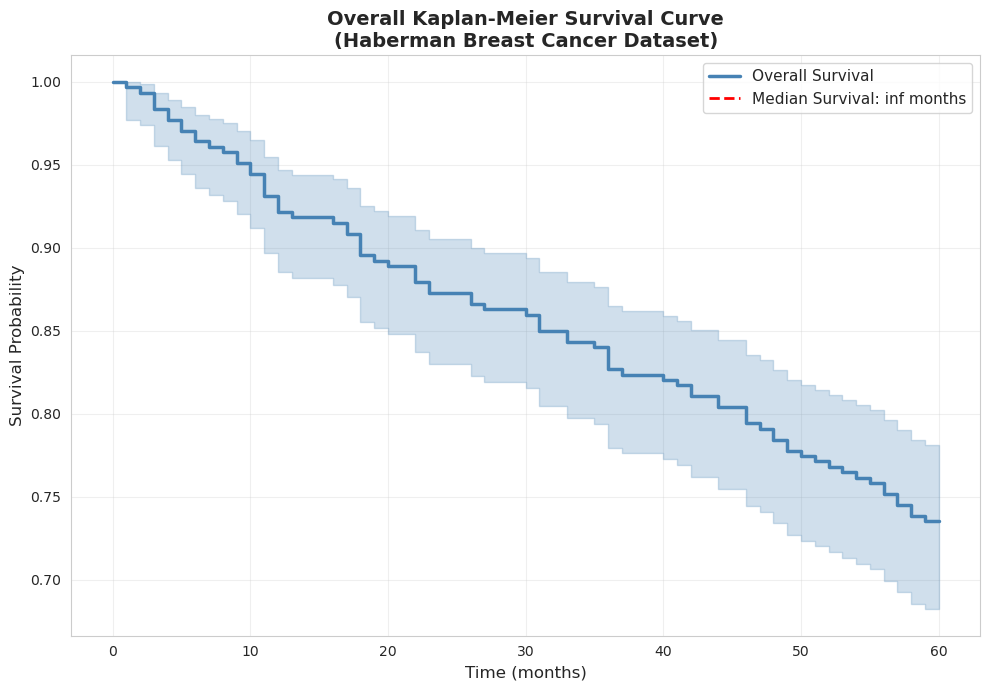

OVERALL SURVIVAL STATISTICS

Median survival time: inf months

Survival at key timepoints:
  12 months: 0.922 (92.2%)
  24 months: 0.873 (87.3%)
  36 months: 0.827 (82.7%)
  48 months: 0.784 (78.4%)
  60 months: 0.735 (73.5%)

Total patients: 306
Events (deaths): 81 (26.5%)
Censored (survived): 225 (73.5%)


In [17]:
# Overall Kaplan-Meier Survival Curve
kmf = KaplanMeierFitter()

# Fit K-M estimator on all data
kmf.fit(data_clean['time'], data_clean['event'], label='Overall Survival')

# Create figure with proper sizing
fig, ax = plt.subplots(figsize=(10, 7))

# Plot survival curve with confidence intervals
kmf.plot_survival_function(ax=ax, ci_show=True, color='steelblue', linewidth=2.5)

# Add formatting
ax.set_xlabel('Time (months)', fontsize=12)
ax.set_ylabel('Survival Probability', fontsize=12)
ax.set_title('Overall Kaplan-Meier Survival Curve\n(Haberman Breast Cancer Dataset)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=11)

# Add median survival time
median_survival = kmf.median_survival_time_
if pd.notna(median_survival):
    ax.axvline(x=median_survival, color='red', linestyle='--', linewidth=2, 
               label=f'Median Survival: {median_survival:.0f} months')
    ax.legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

# Print survival statistics
print("=" * 70)
print("OVERALL SURVIVAL STATISTICS")
print("=" * 70)
print(f"\nMedian survival time: {median_survival:.2f} months")
print(f"\nSurvival at key timepoints:")
for t in [12, 24, 36, 48, 60]:
    survival_prob = kmf.predict(t)
    print(f"  {t} months: {survival_prob:.3f} ({survival_prob*100:.1f}%)")
    
print(f"\nTotal patients: {len(data_clean)}")
print(f"Events (deaths): {data_clean['event'].sum()} ({data_clean['event'].sum()/len(data_clean)*100:.1f}%)")
print(f"Censored (survived): {(data_clean['event']==0).sum()} ({(data_clean['event']==0).sum()/len(data_clean)*100:.1f}%)")


### Stratified Kaplan-Meier Curves

Compare survival across different patient subgroups.


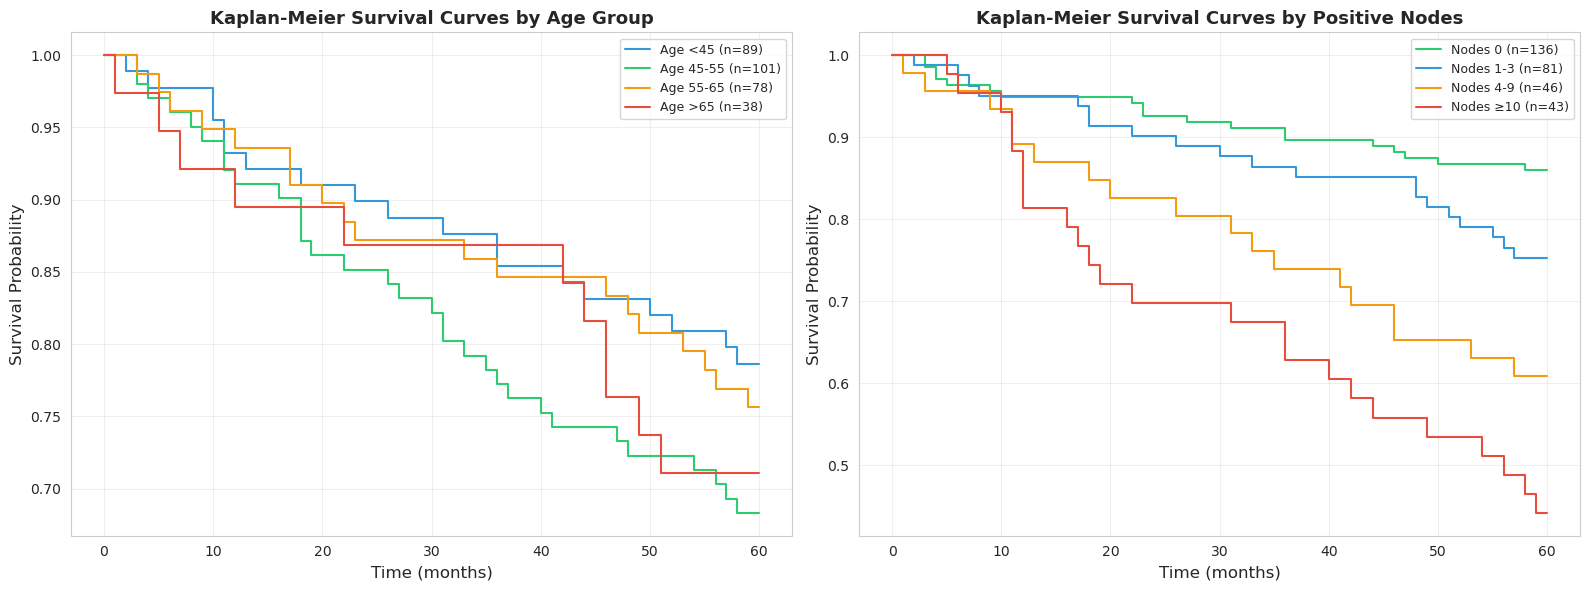

In [18]:
# Stratified K-M Curves by Age Groups and Node Categories
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Age groups stratification
age_groups = ['<45', '45-55', '55-65', '>65']
colors_age = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
ax1 = axes[0]

for idx, group in enumerate(age_groups):
    group_data = data_clean[data_clean['age_group'] == group]
    if len(group_data) > 0:
        kmf_age = KaplanMeierFitter()
        kmf_age.fit(group_data['time'], group_data['event'], label=f'Age {group} (n={len(group_data)})')
        kmf_age.plot_survival_function(ax=ax1, ci_show=False, color=colors_age[idx])

ax1.set_xlabel('Time (months)', fontsize=12)
ax1.set_ylabel('Survival Probability', fontsize=12)
ax1.set_title('Kaplan-Meier Survival Curves by Age Group', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', fontsize=9)

# Node categories stratification
node_categories = ['0', '1-3', '4-9', '≥10']
colors_nodes = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']
ax2 = axes[1]

for idx, category in enumerate(node_categories):
    category_data = data_clean[data_clean['node_category'] == category]
    if len(category_data) > 0:
        kmf_node = KaplanMeierFitter()
        kmf_node.fit(category_data['time'], category_data['event'], 
                     label=f'Nodes {category} (n={len(category_data)})')
        kmf_node.plot_survival_function(ax=ax2, ci_show=False, color=colors_nodes[idx])

ax2.set_xlabel('Time (months)', fontsize=12)
ax2.set_ylabel('Survival Probability', fontsize=12)
ax2.set_title('Kaplan-Meier Survival Curves by Positive Nodes', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()


## 2. Log-Rank Tests

The log-rank test compares survival curves between groups to determine if there are statistically significant differences in survival.


In [19]:
# Log-Rank Tests for Age Groups
print("=" * 70)
print("LOG-RANK TESTS: Age Groups")
print("=" * 70)

# Prepare data for each age group
age_group_data = []
age_group_labels = []

for group in ['<45', '45-55', '55-65', '>65']:
    group_data = data_clean[data_clean['age_group'] == group]
    if len(group_data) > 5:  # Only include groups with sufficient data
        age_group_data.append((group_data['time'], group_data['event']))
        age_group_labels.append(group)

# Perform log-rank test
results = multivariate_logrank_test(
    data_clean['time'],
    data_clean['age_group'], 
    data_clean['event']
)

print(f"\nOmnibus test (all age groups):")
print(f"  Chi-square statistic: {results.test_statistic:.4f}")
print(f"  P-value: {results.p_value:.6f}")
print(f"  Degrees of freedom: {results.degrees_of_freedom}")
print(f"  Interpretation: {'Significant difference (p < 0.05)' if results.p_value < 0.05 else 'No significant difference (p ≥ 0.05)'}")

# Pairwise comparisons
if len(age_group_labels) > 2:
    print("\nPairwise log-rank tests:")
    for i in range(len(age_group_labels)):
        for j in range(i+1, len(age_group_labels)):
            group1 = age_group_labels[i]
            group2 = age_group_labels[j]
            result = logrank_test(
                data_clean[data_clean['age_group'] == group1]['time'],
                data_clean[data_clean['age_group'] == group2]['time'],
                data_clean[data_clean['age_group'] == group1]['event'],
                data_clean[data_clean['age_group'] == group2]['event']
            )
            significance = '*' if result.p_value < 0.05 else ''
            print(f"  {group1} vs {group2}: p = {result.p_value:.4f} {significance}")


LOG-RANK TESTS: Age Groups

Omnibus test (all age groups):
  Chi-square statistic: 3.0121
  P-value: 0.389768
  Degrees of freedom: 3
  Interpretation: No significant difference (p ≥ 0.05)

Pairwise log-rank tests:
  <45 vs 45-55: p = 0.1069 
  <45 vs 55-65: p = 0.6586 
  <45 vs >65: p = 0.3604 
  45-55 vs 55-65: p = 0.2662 
  45-55 vs >65: p = 0.7255 
  55-65 vs >65: p = 0.5763 


In [20]:
# Log-Rank Tests for Node Categories
print("\n" + "=" * 70)
print("LOG-RANK TESTS: Node Categories")
print("=" * 70)

results = multivariate_logrank_test(
    data_clean['time'],
    data_clean['node_category'], 
    data_clean['event']
)

print(f"\nOmnibus test (all node categories):")
print(f"  Chi-square statistic: {results.test_statistic:.4f}")
print(f"  P-value: {results.p_value:.6f}")
print(f"  Degrees of freedom: {results.degrees_of_freedom}")
print(f"  Interpretation: {'Significant difference (p < 0.05)' if results.p_value < 0.05 else 'No significant difference (p ≥ 0.05)'}")

# Pairwise comparisons
node_labels = ['0', '1-3', '4-9', '≥10']
print("\nPairwise log-rank tests:")
for i in range(len(node_labels)):
    for j in range(i+1, len(node_labels)):
        cat1 = node_labels[i]
        cat2 = node_labels[j]
        if len(data_clean[data_clean['node_category'] == cat1]) > 3 and len(data_clean[data_clean['node_category'] == cat2]) > 3:
            result = logrank_test(
                data_clean[data_clean['node_category'] == cat1]['time'],
                data_clean[data_clean['node_category'] == cat2]['time'],
                data_clean[data_clean['node_category'] == cat1]['event'],
                data_clean[data_clean['node_category'] == cat2]['event']
            )
            significance = '*' if result.p_value < 0.05 else ''
            print(f"  Nodes {cat1} vs Nodes {cat2}: p = {result.p_value:.4f} {significance}")



LOG-RANK TESTS: Node Categories

Omnibus test (all node categories):
  Chi-square statistic: 36.8944
  P-value: 0.000000
  Degrees of freedom: 3
  Interpretation: Significant difference (p < 0.05)

Pairwise log-rank tests:
  Nodes 0 vs Nodes 1-3: p = 0.0546 
  Nodes 0 vs Nodes 4-9: p = 0.0002 *
  Nodes 0 vs Nodes ≥10: p = 0.0000 *
  Nodes 1-3 vs Nodes 4-9: p = 0.0708 
  Nodes 1-3 vs Nodes ≥10: p = 0.0003 *
  Nodes 4-9 vs Nodes ≥10: p = 0.1313 


## 3. Cox Proportional Hazards Regression

The Cox model estimates how covariates affect the hazard (risk) of the event occurring.


In [21]:
# Prepare data for Cox regression (only continuous variables for main model)
cox_data = data_clean[['time', 'event', 'Age', 'Operation_year', 'Nb_pos_detected']].copy()

print("=" * 70)
print("UNIVARIATE COX REGRESSION MODELS")
print("=" * 70)

# Univariate models
univariate_results = []

covariates = ['Age', 'Operation_year', 'Nb_pos_detected']

for cov in covariates:
    print(f"\n{cov}:")
    
    # Fit univariate Cox model
    cph_uni = CoxPHFitter()
    cph_uni.fit(cox_data[['time', 'event', cov]], duration_col='time', event_col='event')
    
    # Extract results
    # Note: hazard_ratios_ already returns exponentiated HRs, so no need to exp() again
    hr = cph_uni.hazard_ratios_[cov]
    # Access confidence intervals - column names are typically 'lower 0.95' and 'upper 0.95'
    ci_cols = cph_uni.confidence_intervals_.columns
    # confidence_intervals_ also already contains exponentiated values
    ci_lower = cph_uni.confidence_intervals_.loc[cov, ci_cols[0]]
    ci_upper = cph_uni.confidence_intervals_.loc[cov, ci_cols[1]]
    p_value = cph_uni.summary.loc[cov, 'p']
    
    print(f"  Hazard Ratio: {hr:.3f} (95% CI: {ci_lower:.3f} - {ci_upper:.3f})")
    print(f"  P-value: {p_value:.6f}")
    
    if cov == 'Nb_pos_detected':
        interpretation = f"Each additional positive node increases death risk by {(hr-1)*100:.1f}%"
    elif cov == 'Age':
        interpretation = f"Each additional year of age increases death risk by {(hr-1)*100:.1f}%"
    else:
        interpretation = f"Each additional operation year increases death risk by {(hr-1)*100:.1f}%"
    
    print(f"  Interpretation: {interpretation}")
    print(f"  {'Significant' if p_value < 0.05 else 'Not significant'}")
    
    univariate_results.append({
        'Covariate': cov,
        'HR': hr,
        'CI_lower': ci_lower,
        'CI_upper': ci_upper,
        'p_value': p_value
    })

# Create summary table
uni_df = pd.DataFrame(univariate_results)
print("\n\nSummary of Univariate Cox Models:")
print(uni_df.to_string(index=False))


UNIVARIATE COX REGRESSION MODELS

Age:
  Hazard Ratio: 1.012 (95% CI: -0.008 - 0.032)
  P-value: 0.245703
  Interpretation: Each additional year of age increases death risk by 1.2%
  Not significant

Operation_year:
  Hazard Ratio: 0.994 (95% CI: -0.072 - 0.061)
  P-value: 0.862964
  Interpretation: Each additional operation year increases death risk by -0.6%
  Not significant

Nb_pos_detected:
  Hazard Ratio: 1.049 (95% CI: 0.030 - 0.066)
  P-value: 0.000000
  Interpretation: Each additional positive node increases death risk by 4.9%
  Significant


Summary of Univariate Cox Models:
      Covariate       HR  CI_lower  CI_upper      p_value
            Age 1.011839 -0.008102  0.031640 2.457034e-01
 Operation_year 0.994150 -0.072496  0.060761 8.629643e-01
Nb_pos_detected 1.048754  0.029611  0.065595 2.151573e-07
